# DUTCH Fastshap vs FastShap with DP

In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch

# import from parent level
import sys
import copy

sys.path.append("../")
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from Utils.utils import Utils
from Client.client_explainer import prepare_dataset_for_explainer_FL


import os
import torch
import torch.nn as nn
from fastshap.surrogate_dp import SurrogateDP

import sys

sys.path.append("../")
from pathlib import Path
from fastshap.fastshap_dp import (
    FastSHAP,
    calculate_grand_coalition_FL,
    validate_FL,
)

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 10:48:44,281	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Functions

In [2]:
def prepare_data_FL(
    test_clients,
    batch_size,
    dataset_name,
    num_workers,
    fed_dir,
    device,
    num_features,
    surrogate,
    seed=42,
):
    samples, targets = [], []
    for client in test_clients:
        data = Utils.get_dataset(
            path_to_data=Path(fed_dir),
            cid=client,
            dataset=dataset_name,
            partition="train",
        )
        for item in data:
            X, _, y = item
            samples.append(X)
            targets.append(y)

    return samples, targets

In [ ]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(
    explanation_file_name, explainer, model, x, y, index, base_value, base_path
):
    if not os.path.isfile(
        f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
    ):
        fastshap_explanation = explainer.shap_values(x)[0][:, y]
        torch.save(
            fastshap_explanation,
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
        )

    if not os.path.isfile(
        f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    ):
        faithfulness = compute_faithfulness(
            x,
            y,
            fastshap_explanation,
            model,
            base_value=base_value,
        )
        torch.save(
            faithfulness,
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt",
        )
    else:
        faithfulness = torch.load(
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
        )
    return fastshap_explanation, faithfulness

In [4]:
class Args:
    def __init__(self):
        self.dataset_name = "adult"
        self.sweep = True


# args = Args()
# args.seed = 42
# args.sweep = False
# args.dataset_name = "dutch"
# (
#     train_set,
#     val_set,
#     test_set,
#     X_train,
#     X_val,
#     X_test,
#     Y_train,
#     Y_val,
#     Y_test,
#     num_features,
#     feature_names,
# ) = prepare_data(args)


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = np.std(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = np.std(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = np.std(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = np.std(faithfulness_eps_2)

    mean_eps_3 = np.mean(faithfulness_eps_3)
    std_eps_3 = np.std(faithfulness_eps_3)

    mean_eps_4 = np.mean(faithfulness_eps_4)
    std_eps_4 = np.std(faithfulness_eps_4)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = np.std(faithfulness_eps_5)

    mean_eps_10 = np.mean(faithfulness_eps_10)
    std_eps_10 = np.std(faithfulness_eps_10)

    mean_eps_100 = np.mean(faithfulness_eps_100)
    std_eps_100 = np.std(faithfulness_eps_100)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 3": [mean_eps_3],
        "Eps. 4": [mean_eps_4],
        "Eps. 5": [mean_eps_5],
        "Eps. 10": [mean_eps_10],
        "Eps. 100": [mean_eps_100],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 3": [std_eps_3],
        "Eps. 4": [std_eps_4],
        "Eps. 5": [std_eps_5],
        "Eps. 10": [std_eps_10],
        "Eps. 100": [std_eps_100],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_error_bar(
    labels, results_mean, results_std, y_label, title, y_lim=None, x_ticks=None
):
    means = [results_mean[label] for label in labels]
    errors = [results_std[label] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel(y_label, fontsize=14)
    plt.title(
        title,
        fontsize=16,
    )
    # y lim
    if y_lim:
        plt.ylim(y_lim)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.xticks(rotation=90)

    # Chnge the labels of the x axis
    if x_ticks:
        plt.xticks(range(len(labels)), x_ticks, fontsize=12)
    else:
        plt.xticks(range(len(labels)), labels, fontsize=12)

    plt.show()

In [6]:
def load_data(
    private_model: bool,
    private_surrogate: bool,
    explainer_privacy_levels: list,
    base_path: str,
    model_name: str,
    surrogate_name: str,
    explainer_name: str,
    device: str,
    num_features: int,
    eps_bb: str = "",
):
    loaded_data = {}
    loaded_data["private_model"] = private_model
    loaded_data["private_surrogate"] = private_surrogate
    private_model_str = "private_model_" if private_model else ""

    if os.path.isfile(
        f"{base_path}bb/{model_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved model")
        model = torch.load(
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to("cpu")
        model_aix = aix_model(model)
    else:
        print(
            f"Model not found: {base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        )

    # Surrogate model without DP
    if os.path.isfile(
        f"{base_path}/surrogate/{surrogate_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved surrogate model")
        surr = torch.load(
            f"{base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to(device)
        surrogate = Surrogate(surr, num_features)
    else:
        print(
            f"Surrogate model not found: {base_path}/surrogate/{surrogate_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        )

    loaded_data["model"] = model
    loaded_data["model_aix"] = model_aix
    loaded_data["surrogate"] = surrogate

    for eps in explainer_privacy_levels:
        # DP 0.5
        if os.path.isfile(f"{base_path}/explainer/{explainer_name}_{eps}.pth"):
            print("Loading saved explainer model")
            explainer = torch.load(
                f"{base_path}/explainer/{explainer_name}_{eps}.pth"
            ).to(device)
            fastshap = FastSHAP(
                explainer,
                surrogate,
                normalization="none",
                link=nn.Softmax(dim=-1),
                num_features=num_features,
            )
            loaded_data[f"explainer_{eps}"] = fastshap
        else:
            print(
                f"Explainer model not found: {base_path}/explainer/{explainer_name}_{private_model_str}{eps}.pth"
            )
    return loaded_data

In [7]:
def get_explanations(
    model_predictions: list,
    X_test,
    loaded_data: dict,
    base_value: float,
    base_path: str,
    explainer_privacy_levels: list,
):
    for privacy_level in explainer_privacy_levels:
        faithfulness = []
        explanations = []
        for index, (x, y) in enumerate(zip(X_test, model_predictions)):
            y = 0 if not y else 1
            x = np.array([list(x)])

            shap_NO_DP, faithfulness_NO_DP = process_explainer(
                f"private_model_{loaded_data['private_model']}_surrogate_{loaded_data['private_surrogate']}_explainer_{privacy_level}",
                loaded_data[f"explainer_{privacy_level}"],
                loaded_data["model_aix"],
                x,
                y,
                index,
                base_value,
                base_path=base_path,
            )
            explanations.append(copy.deepcopy(shap_NO_DP))
            faithfulness.append(faithfulness_NO_DP)
            loaded_data[f"explanations_{privacy_level}"] = explanations
            loaded_data[f"faithfulness_{privacy_level}"] = faithfulness

In [8]:
def plot_base_explainer_shap_values(
    loaded_data, explainer_privacy_levels, X_test, feature_names, title, explainer_name
):
    explanations = []
    for index in range(len(X_test)):
        fastshap_NO_DP = loaded_data[explainer_name][index]
        # compute the absolute values of the shap values
        fastshap_NO_DP = np.abs(fastshap_NO_DP)
        explanations.append(fastshap_NO_DP)

    # mean of the absolute values of the shap values
    mean_explanations = np.mean(explanations, axis=0)
    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations)[::-1]
    print(len(sorted_indices))
    print(len(feature_names))
    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))
    plt.bar(
        [feature_names[i] for i in sorted_indices], mean_explanations[sorted_indices]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Mean SHAP Value")
    plt.title(title)
    plt.show()

In [9]:
def create_dictionaries_metrics(explainer_privacy_levels, metrics, current_metric):
    mean = {}
    std = {}
    for privacy_level in explainer_privacy_levels:
        mean["Epsilon " + privacy_level.split("_")[1]] = np.mean(
            metrics[current_metric + privacy_level]
        )
        std["Epsilon " + privacy_level.split("_")[1]] = np.std(
            metrics[current_metric + privacy_level]
        )
    return mean, std

In [10]:
def get_model_predictions(model, X_test):
    model_predictions = []
    for x in X_test:
        model_prediction = model(torch.Tensor(x).unsqueeze(0)).argmax()
        model_predictions.append(model_prediction)
    return model_predictions

In [11]:
def compute_metrics(
    X_test, loaded_data, explainer_privacy_levels, selected_features, all_features
):
    metrics = {}
    for privacy_level in explainer_privacy_levels:
        L2_distances = []
        spearman_correlation = []
        cosine_similarity = []
        kendall_tau = []

        for index in range(len(X_test)):
            selected_indexes = [
                all_features.index(feature) for feature in selected_features
            ]

            explanation_NO_DP = loaded_data["explanations_NO_DP"][index][
                selected_indexes
            ]

            explanation_DP = loaded_data[f"explanations_{privacy_level}"][index][
                selected_indexes
            ]

            L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
            coef, p = spearmanr(explanation_DP, explanation_NO_DP)
            spearman_correlation.append(coef)
            cosine_similarity.append(
                np.dot(explanation_DP, explanation_NO_DP)
                / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
            )
            tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
            kendall_tau.append(tau)

        metrics[f"L2_{privacy_level}"] = L2_distances
        metrics[f"spearman_{privacy_level}"] = spearman_correlation
        metrics[f"cosine_{privacy_level}"] = cosine_similarity
        metrics[f"kendall_{privacy_level}"] = kendall_tau
    return metrics

In [12]:
def normalize_explanations(data, explainer_privacy_levels, rescale_to):
    # Normalize explanations
    num_data = len(data[f"explanations_NO_DP"])
    min_max = [[float("inf"), -float("inf")] for _ in range(num_data)]

    for privacy_level in explainer_privacy_levels:
        current_explanation = data[f"explanations_{privacy_level}"]
        for index, explanation in enumerate(current_explanation):
            max_value = np.max(explanation)
            min_value = np.min(explanation)
            if max_value > min_max[index][1]:
                min_max[index][1] = max_value
            if min_value < min_max[index][0]:
                min_max[index][0] = min_value

    # normalize the explanations
    for privacy_level in explainer_privacy_levels:
        current_explanation = data[f"explanations_{privacy_level}"]

        current_explanations = []
        for index, explanation in enumerate(current_explanation):
            maximum_value = min_max[index][1]
            minimum_value = min_max[index][0]

            if rescale_to == "min_max":
                current_explanation = (explanation - min(explanation)) / (
                    maximum_value - minimum_value
                )

                current_explanation = (
                    ((explanation - min(explanation)) * (maximum_value - minimum_value))
                    / (max(explanation) - min(explanation))
                ) + minimum_value

                # (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin

            elif rescale_to == "minus_one_one":
                current_explanation = (
                    2 * (explanation - minimum_value) / (maximum_value - minimum_value)
                    - 1
                )
            else:
                raise ValueError(
                    "Invalid rescale_to value. Use 'min_max' or 'minus_one_one'."
                )
            current_explanations.append(current_explanation)
        data[f"explanations_{privacy_level}"] = current_explanations

    # Normalize explanations

    minimum_value = float("inf")
    maximum_value = float("-inf")
    for privacy_level in explainer_privacy_levels:
        current_explanation = data[f"explanations_{privacy_level}"]
        for explanation in current_explanation:
            max_value = np.max(explanation)
            min_value = np.min(explanation)
            if max_value > maximum_value:
                maximum_value = max_value
            if min_value < minimum_value:
                minimum_value = min_value

    print(minimum_value, maximum_value)

# FL Experiments

In [13]:
test_nodes = ["25", "23", "19", "11", "4", "45", "26", "9", "29", "16"]
explainer_privacy_levels = ["NO_DP", "DP_01", "DP_05", "DP_1", "DP_2", "DP_1000"]
bb_privacy_levels = ["NO_DP"]
feature_names = [
    "age",
    "household_position",
    "household_size",
    "prev_residence_place",
    "citizenship",
    "country_birth",
    "edu_level",
    "economic_status",
    "cur_eco_activity",
    "Marital_status",
    "sex_binary",
    "bias",
]

In [22]:
loaded_data_NO_DP_bb = load_data(
    private_model=False,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path="../../../artifacts/dutch_federated_cros_device/",
    model_name="bb",
    surrogate_name="dutch_surrogate",
    explainer_name="explainer",
    device="cuda",
    num_features=12,
)

Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model


/tmp/ipykernel_3584940/3085278128.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(
/tmp/ipykernel_3584940/3085278128.py:44: FutureWarning: You are us

In [23]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=32,
    dataset_name="dutch",
    num_workers=0,
    fed_dir="../../../data/dutch/federated/",
    device="cuda",
    num_features=12,
    seed=42,
    surrogate=loaded_data_NO_DP_bb["surrogate"],
)

In [24]:
# predictions with BB model

loaded_data_NO_DP_bb["model_predictions"] = get_model_predictions(
    model=loaded_data_NO_DP_bb["model"], X_test=X_test
)

In [25]:
#  use this matrix of ones to
ones = torch.ones(1, 12, dtype=torch.float32, device="cuda")

surrogate_output = []
for x in X_test:
    output = loaded_data_NO_DP_bb["surrogate"](
        torch.tensor(x).to("cuda"), ones[: len(x)].to("cuda")
    )
    surrogate_output.append(output.cpu().detach().numpy())

surrogate_output = np.array(surrogate_output)

In [26]:
surrogate_outputs = [np.argmax(item, axis=1)[0] for item in surrogate_output]

model_predictions = [item.item() for item in loaded_data_NO_DP_bb["model_predictions"]]

In [27]:
# compare surrogate_output with model_predictions and compute the model fidelity

model_fidelity = np.sum(
    np.array(surrogate_outputs) == np.array(model_predictions)
) / len(model_predictions)

print(f"Model fidelity: {model_fidelity}")

Model fidelity: 0.9754474529600734


In [28]:
# Compute the base value

base_value = np.mean(X_test)
base_value

0.34874296

In [30]:
get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=base_value,
    base_path="../../../artifacts/dutch_federated_cros_device/",
    explainer_privacy_levels=explainer_privacy_levels,
)

In [ ]:
# normalize_explanations(
#     data=loaded_data_NO_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     rescale_to="min_max",
# )

12
12


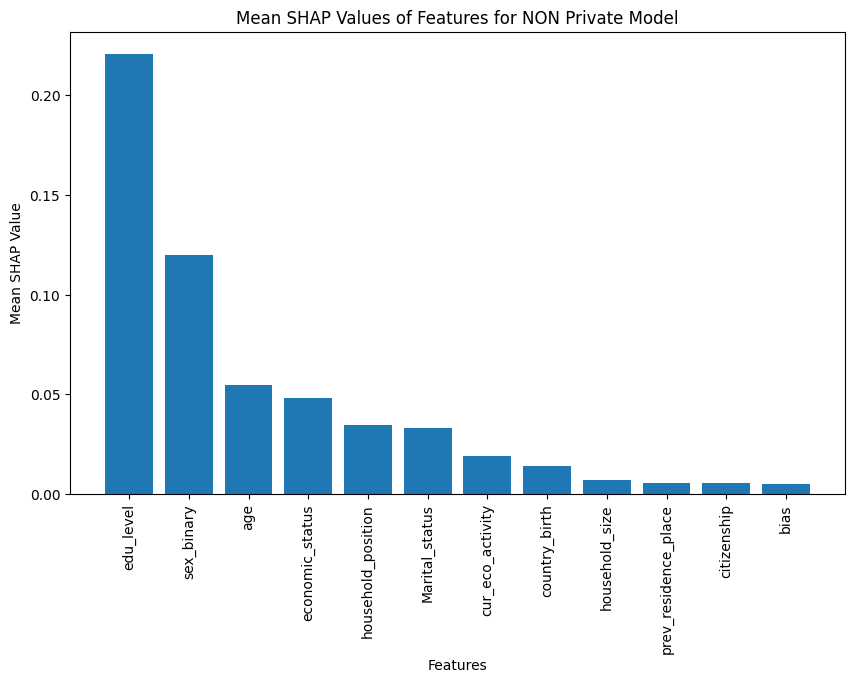

In [31]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP",
)

In [ ]:
top_k_non_private_bb = [
    "edu_level",
    "age",
    "sex_binary",
    "economic_status",
]

# top_k_non_private_bb = [
#     "age",
#     "household_position",
#     "household_size",
#     "prev_residence_place",
#     "citizenship",
#     "country_birth",
#     "edu_level",
#     "economic_status",
#     "cur_eco_activity",
#     "Marital_status",
#     "sex_binary",
# ]

12
12


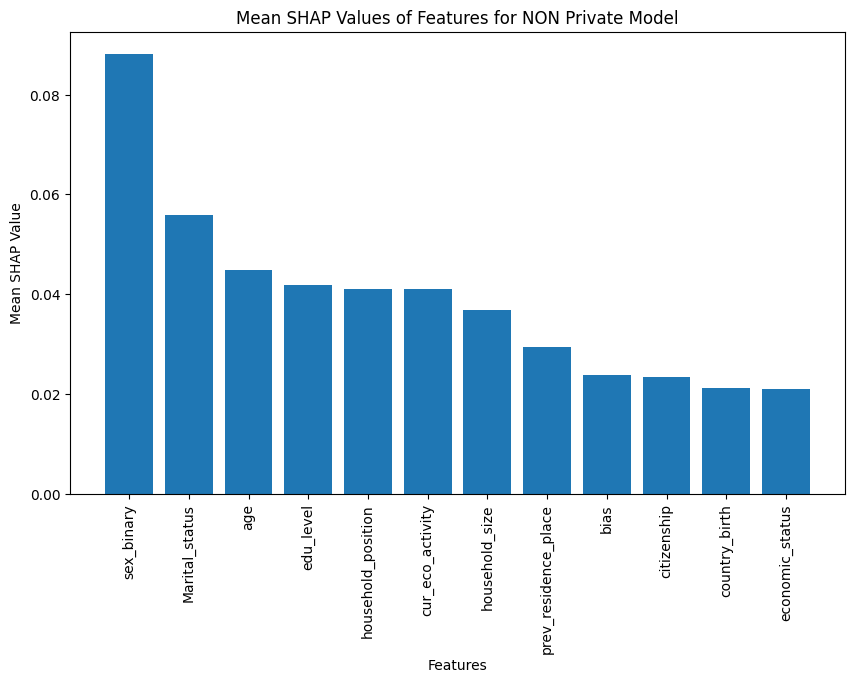

In [33]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_01",
)

12
12


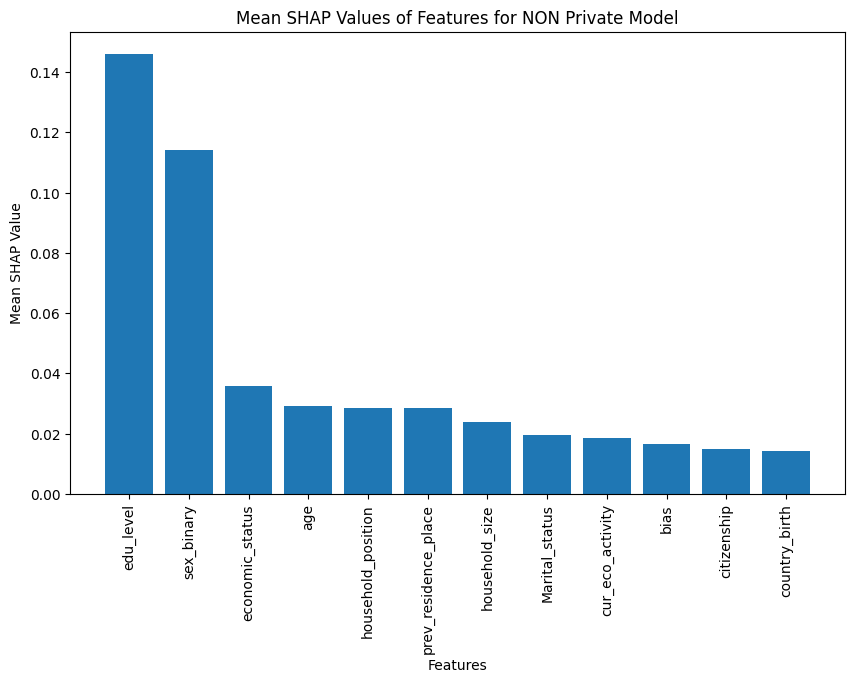

In [34]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_05",
)

12
12


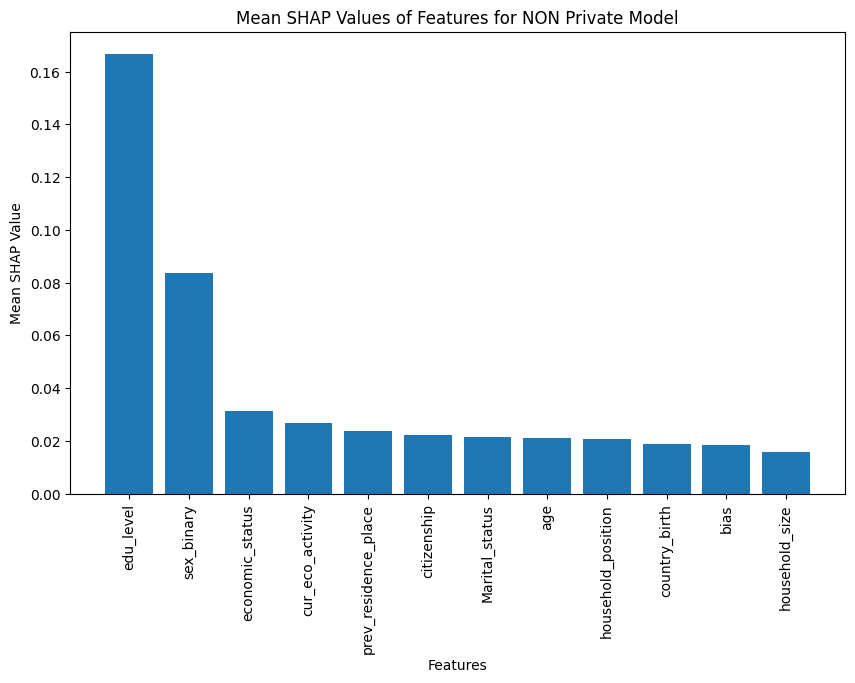

In [35]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_1",
)

12
12


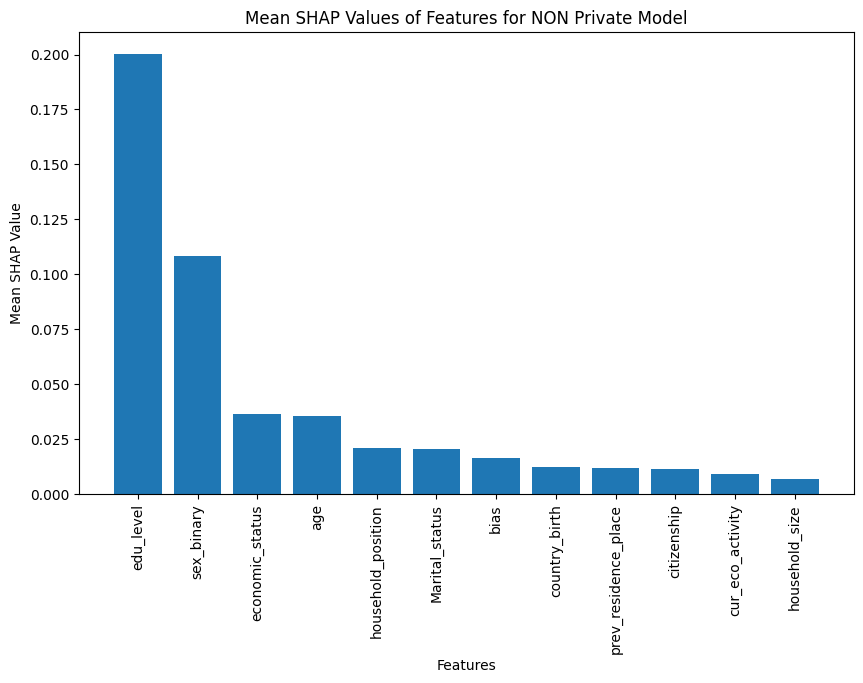

In [36]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_2",
)

12
12


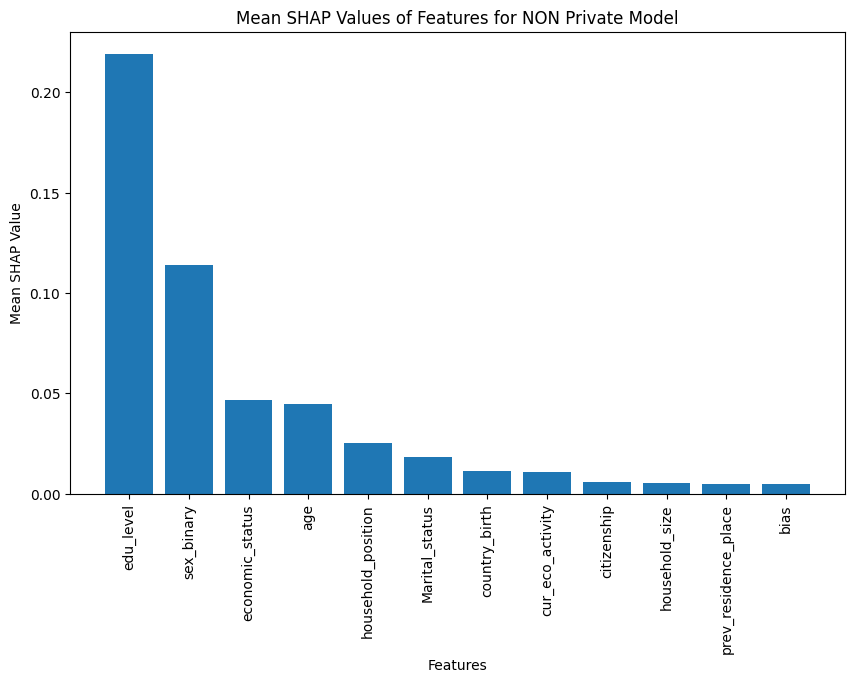

In [37]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_1000",
)

In [38]:
# top_k_non_private_bb = [
#     "age",
#     "household_position",
#     "household_size",
#     "prev_residence_place",
#     "citizenship",
#     "country_birth",
#     "edu_level",
#     "economic_status",
#     "cur_eco_activity",
#     "Marital_status",
#     "sex_binary",
# ]

In [39]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

In [40]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "L2_"
)

In [41]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "cosine_"
)

In [42]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "spearman_"
)

In [43]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "kendall_"
)

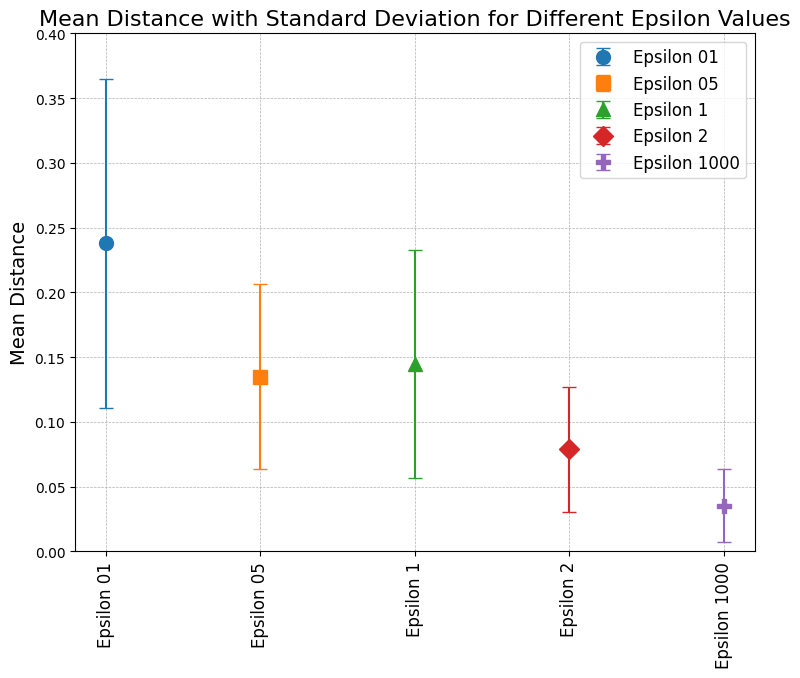

In [44]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=result_std,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 0.4),
)

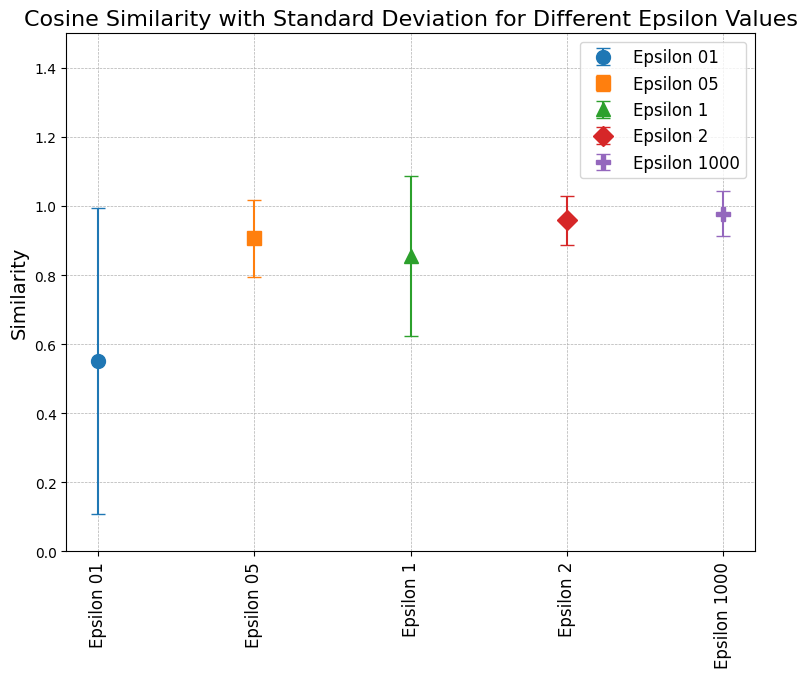

In [45]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean,
    results_std=cosine_std,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.5),
)

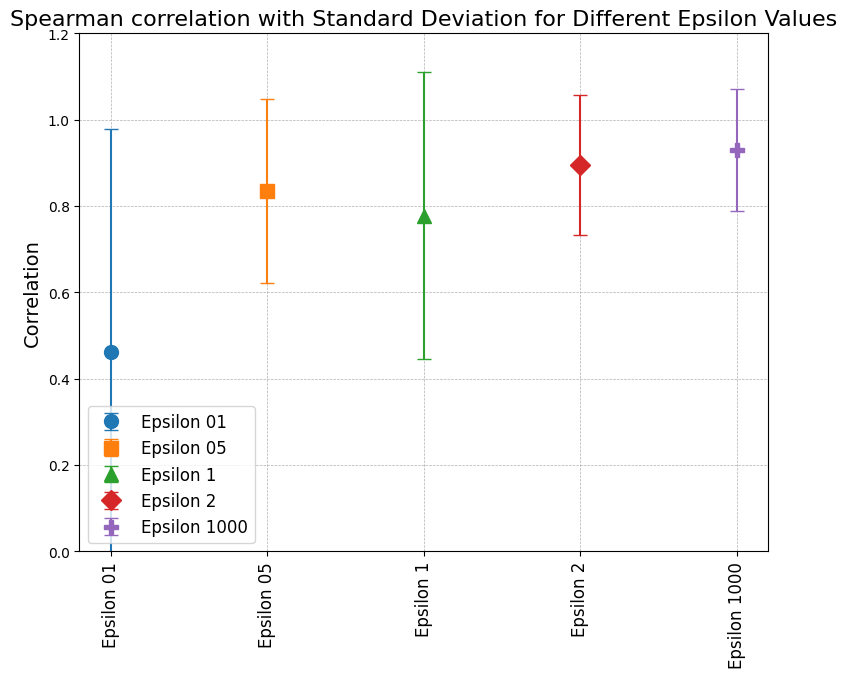

In [46]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean,
    results_std=spearman_std,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.2),
)

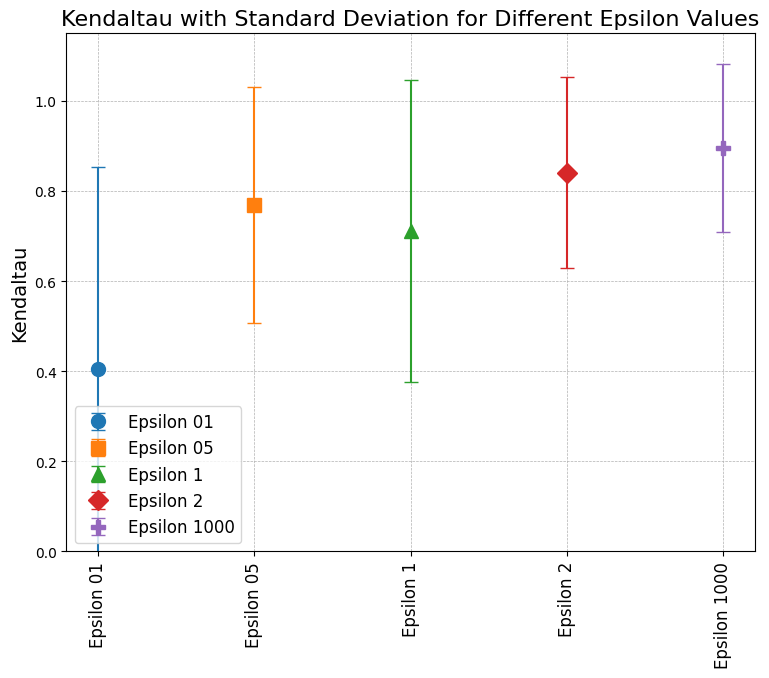

In [47]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean,
    results_std=kendaltau_std,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.15),
)

# With Normalization

In [48]:
get_explanations(
    model_predictions=loaded_data_NO_DP_bb["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_NO_DP_bb,
    base_value=base_value,
    base_path="../../../artifacts/dutch_federated_cros_device/",
    explainer_privacy_levels=explainer_privacy_levels,
)

/tmp/ipykernel_3584940/2104639066.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fastshap_explanation = torch.load(
/tmp/ipykernel_3584940/2104639066.py:62: FutureWarn

In [49]:
normalize_explanations(
    data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    rescale_to="min_max",
)

-0.5375011 0.5688951


12
12


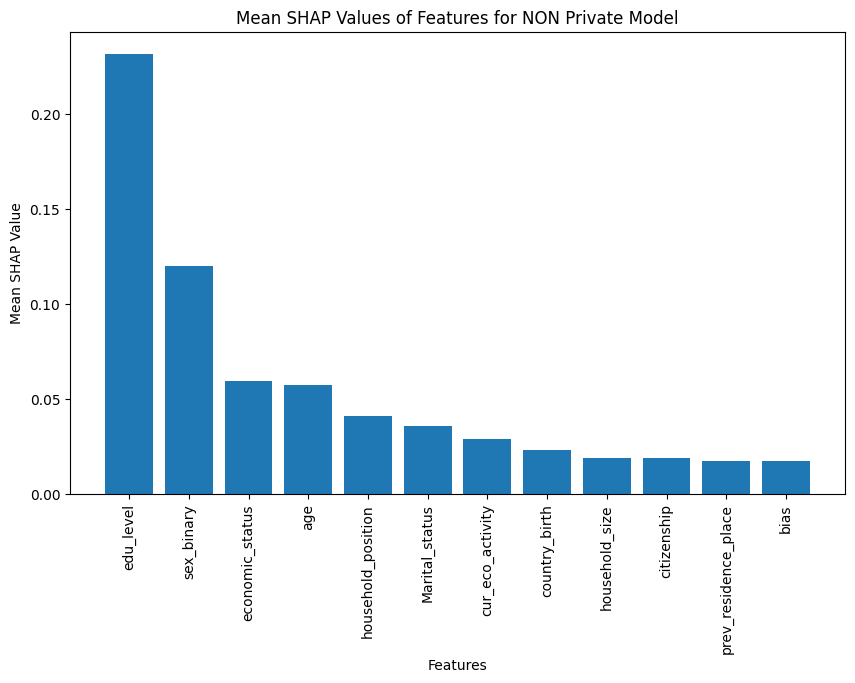

In [50]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_NO_DP",
)

In [51]:
top_k_non_private_bb = [
    "edu_level",
    "citizenship",
    "sex_binary",
    "economic_status",
]

# top_k_non_private_bb = [
#     "age",
#     "household_position",
#     "household_size",
#     "prev_residence_place",
#     "citizenship",
#     "country_birth",
#     "edu_level",
#     "economic_status",
#     "cur_eco_activity",
#     "Marital_status",
#     "sex_binary",
# ]

12
12


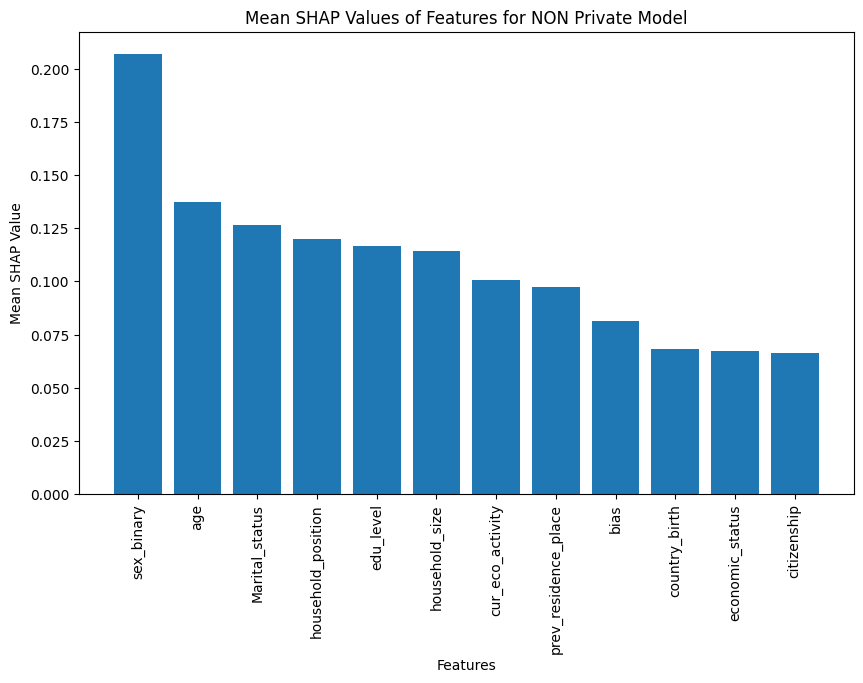

In [52]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_01",
)

12
12


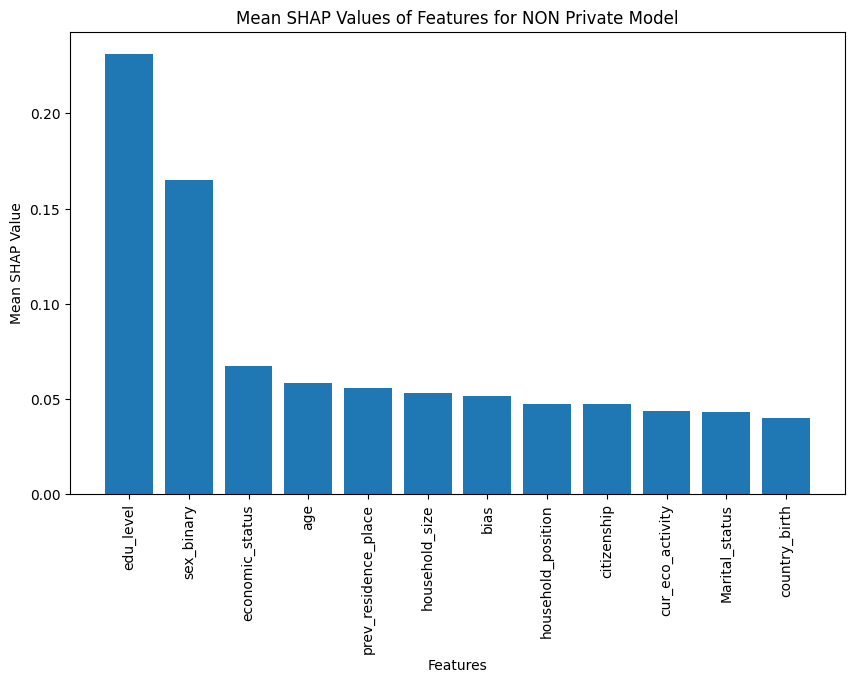

In [53]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_05",
)

12
12


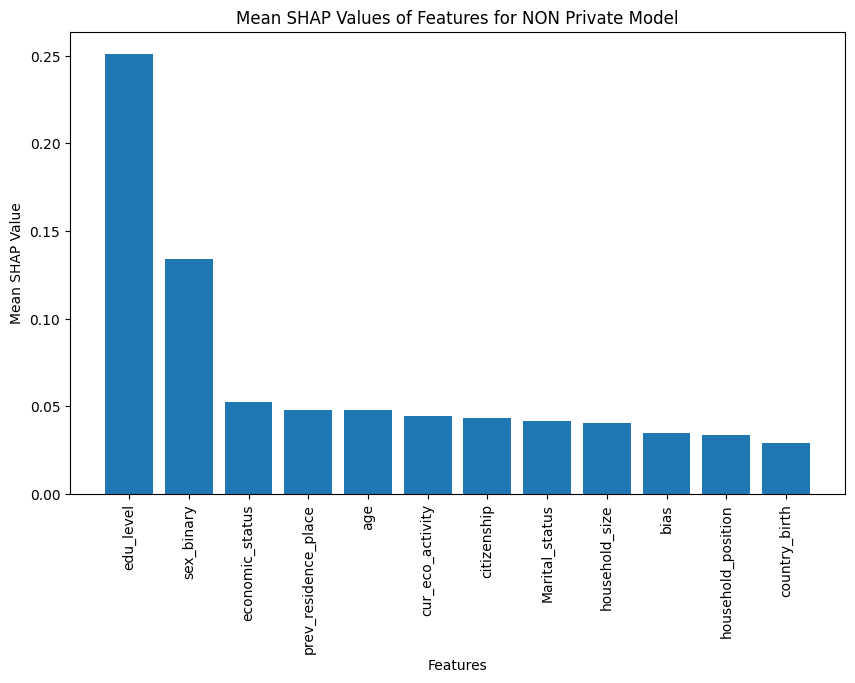

In [54]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_1",
)

12
12


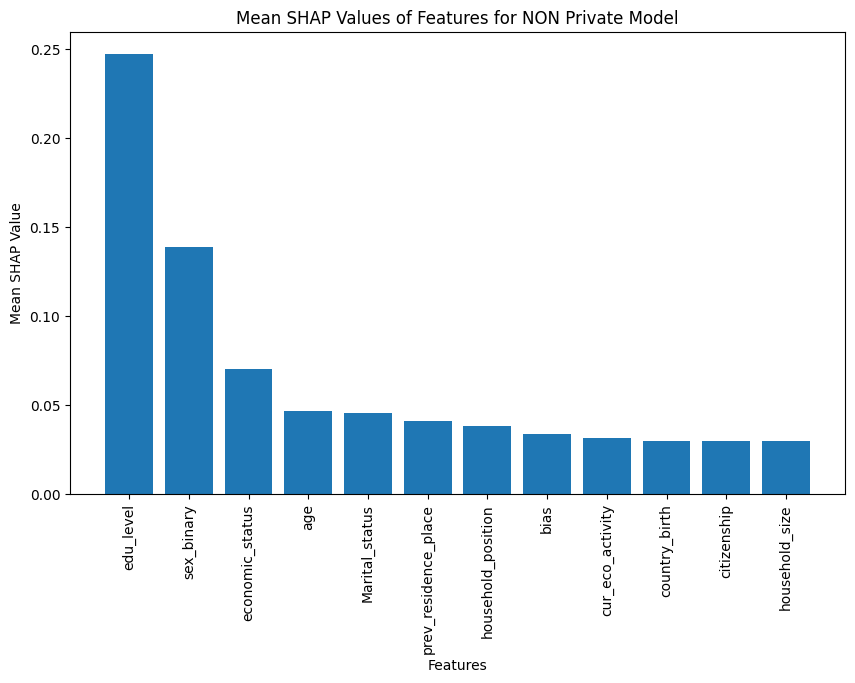

In [55]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_2",
)

12
12


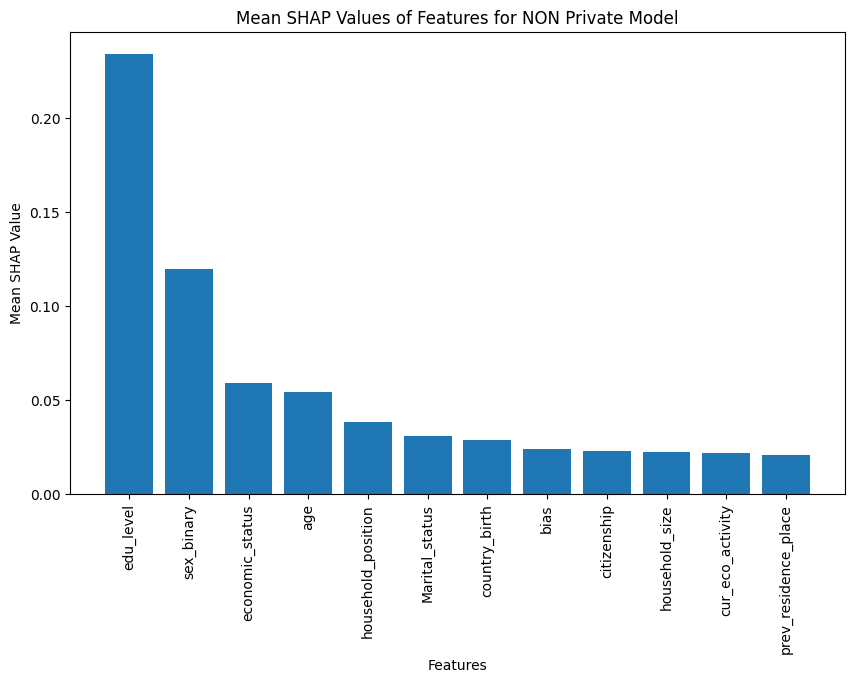

In [56]:
plot_base_explainer_shap_values(
    loaded_data=loaded_data_NO_DP_bb,
    explainer_privacy_levels=explainer_privacy_levels,
    X_test=X_test,
    feature_names=feature_names,
    title="Mean SHAP Values of Features for NON Private Model",
    explainer_name="explanations_DP_1000",
)

In [57]:
# top_k_non_private_bb = [
#     "age",
#     "household_position",
#     "household_size",
#     "prev_residence_place",
#     "citizenship",
#     "country_birth",
#     "edu_level",
#     "economic_status",
#     "cur_eco_activity",
#     "Marital_status",
#     "sex_binary",
# ]

In [58]:
metrics_NO_DP_bb = compute_metrics(
    X_test,
    loaded_data_NO_DP_bb,
    explainer_privacy_levels,
    top_k_non_private_bb,
    feature_names,
)

In [59]:
results_mean, result_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "L2_"
)

In [60]:
cosine_mean, cosine_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "cosine_"
)

In [61]:
spearman_mean, spearman_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "spearman_"
)

In [62]:
kendaltau_mean, kendaltau_std = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_NO_DP_bb, "kendall_"
)

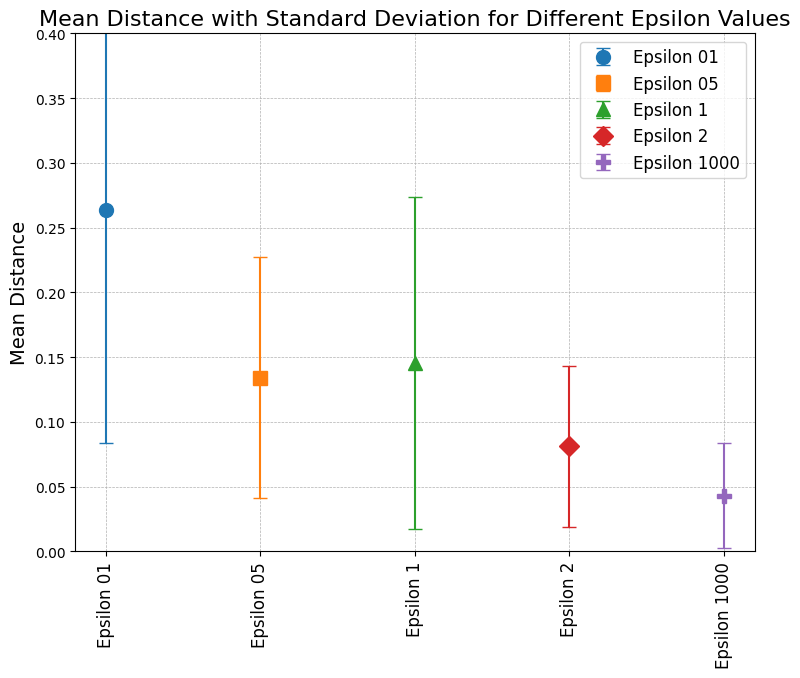

In [63]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=result_std,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 0.4),
)

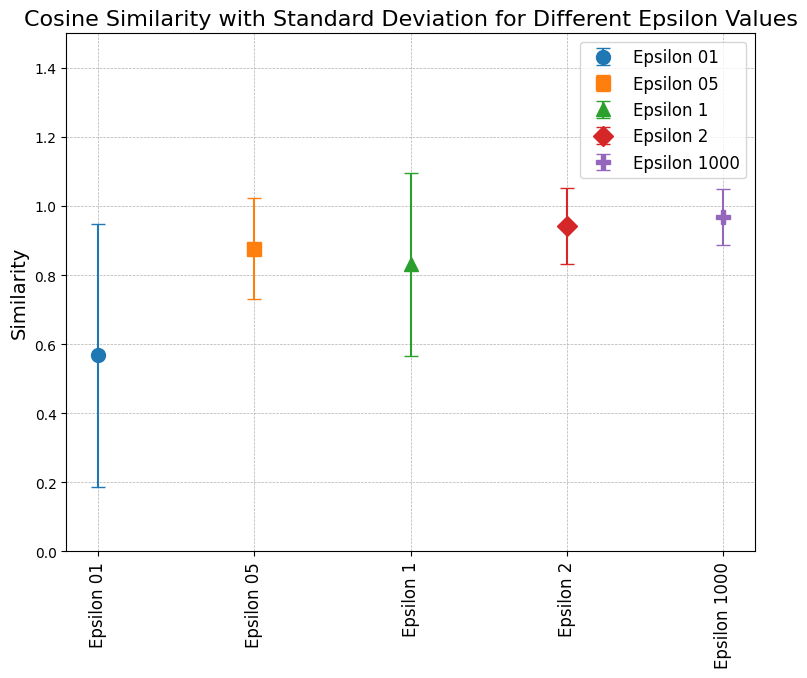

In [64]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean,
    results_std=cosine_std,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.5),
)

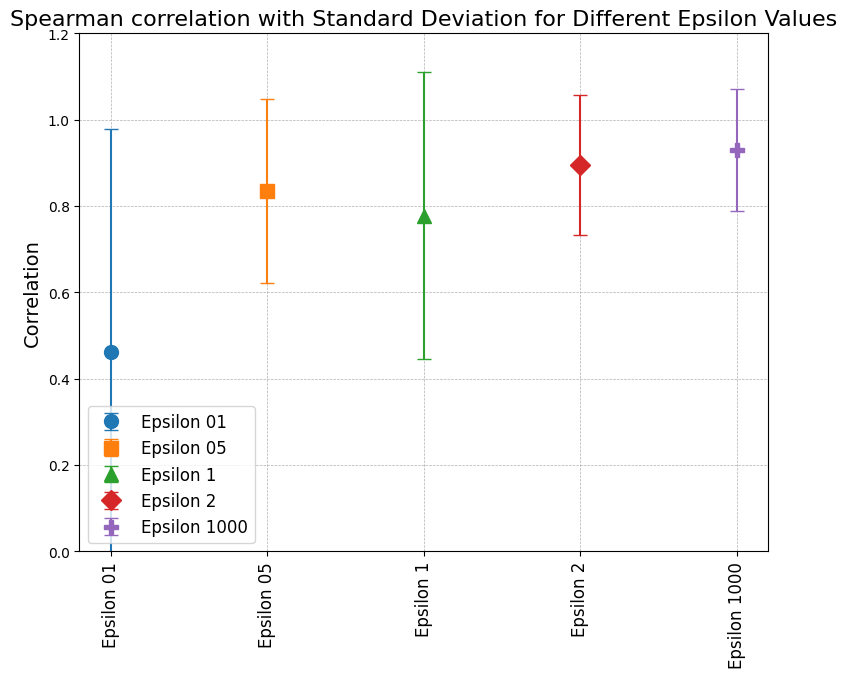

In [65]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean,
    results_std=spearman_std,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.2),
)

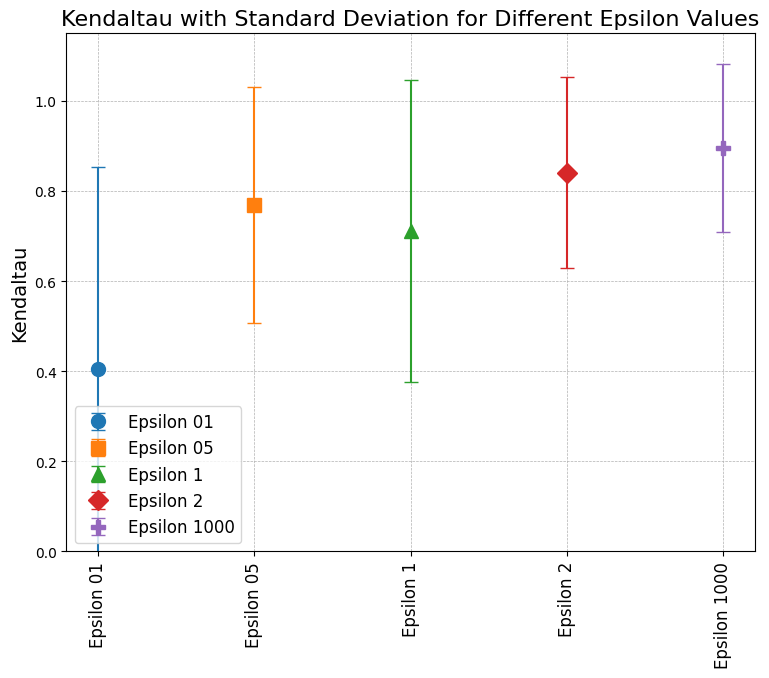

In [66]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean,
    results_std=kendaltau_std,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values",
    y_lim=(0, 1.15),
)

# Faithfulness

In [67]:
from scipy.stats import sem

In [68]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_01,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_1000,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = sem(faithfulness_no_dp)

    mean_eps_01 = np.mean(faithfulness_eps_01)
    std_eps_01 = sem(faithfulness_eps_01)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = sem(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = sem(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = sem(faithfulness_eps_2)

    mean_eps_1000 = np.mean(faithfulness_eps_1000)
    std_eps_1000 = sem(faithfulness_eps_1000)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 01": [mean_eps_01],
        "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 1000": [mean_eps_1000],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 01": [std_eps_01],
        "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 1000": [std_eps_1000],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()

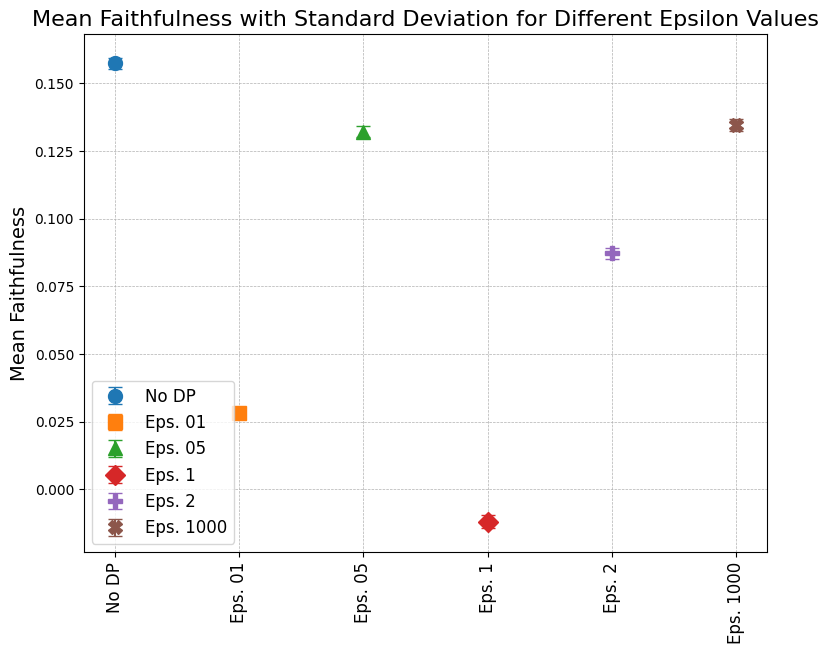

In [69]:
plot_faithfulness_std_dev(
    faithfulness_no_dp=loaded_data_NO_DP_bb["faithfulness_NO_DP"],
    faithfulness_eps_01=loaded_data_NO_DP_bb["faithfulness_DP_01"],
    faithfulness_eps_05=loaded_data_NO_DP_bb["faithfulness_DP_05"],
    faithfulness_eps_1=loaded_data_NO_DP_bb["faithfulness_DP_1"],
    faithfulness_eps_2=loaded_data_NO_DP_bb["faithfulness_DP_2"],
    faithfulness_eps_1000=loaded_data_NO_DP_bb["faithfulness_DP_1000"],
)

In [70]:
# def load_model(model_name):
#     if os.path.isfile(model_name):
#         model = torch.load(model_name)
#     else:
#         raise FileNotFoundError("Model not found")
#     return model

In [71]:
# surrogate = load_model(
#     "../../../artifacts/dutch_federated_cros_device/surrogate/dutch_surrogate_NO_DP.pth"
# )
# surrogate = surrogate.to("cuda")
# surrogate = SurrogateDP(surrogate, num_features=12)

In [72]:
#

In [73]:
# loaded_test_data[0].dataset[0][0]

In [74]:
# explainer = load_model(
#     "../../../artifacts/dutch_federated_cros_device/explainer/explainer_NO_DP.pth"
# )
# explainer = explainer.to("cuda")
# fastshap = FastSHAP(
#     explainer,
#     surrogate,
#     num_features=12,
#     normalization="none",
#     link=nn.Softmax(dim=-1),
# )

In [75]:
# import numpy as np

In [76]:
# x = loaded_test_data[0].dataset[0][0]
# x = np.array([list(x)])
# fastshap.shap_values(x)[0][:, 1]